# Demo: US 2020 Analysis Run

### Summary

This notebook demonstrates an Object Oriented Programming (OOP) implementation of a benchmarking system to compare a FEDS fire perimeter against other fire perimeter data sources, and then store in an output object. 

*This particularly demonstrates ability to iterate over all available FEDS and create mass analysis results*

Sources for demonstration:
- TODO

The FEDS input and reference input can use either a pre-defined setting or can accept (valid) user-written paths to shape files. 
- For Input all settings, please see **section INPUT SETTINGS of README.md**  
- Output settings can also be modified to control if calculations are printed, plotted, and/or stored into a file (with location and file type of choice); for more detail on outputs please see **section OUTPUT SETTINGS of README.md**

#### Motivation 
FEDS-PEC eliminates the need for users to recreate/repeat solutions when conducting geospatial data evaluations. By leveraging this module, researchers and analysts can quickly and efficiently compare the FEDS fireperimeter dataset against a reference data set of their choosing. Users can focus their efforts on dataset selection and analysis, rather than spending time implementing and testing software for comparisons and calculations.

#### Disclaimer
The serializing/plotting portion is incomplete, this notebook does not demonstrate persistence of output. Plotting is also demoed but not yet implemented in the classes as intended.

### User Inputs for Comparison: time, bbox, FEDS set, reference set

Note for inputs:

FEDS Input: you must specify a valid title (e.g. firenrt) and collection (e.g. public.eis_fire_lf_perimeter_archive) according to documentation. Please see **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

Reference Input: See **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

In [1]:
import sys
sys.path.append('/projects/my-public-bucket/VEDA-PEC')

import Utilities
import Input_FEDS
import Input_Reference
import Output_Calculation

from Input_FEDS import InputFEDS
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [2]:
# this is the ONLY thing users are intended to modify!
# inputs for searching FEDS and nifc sets

# START TIME
year_start = 2020
month_start = 7 # 6
day_start = 23 # 1
hour_start = 12
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2020
month_stop = 7
day_stop = 23
hour_stop = 12
minute_stop = 30
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED FEDS FIRE PERIM DEFAULT
crs = 3857 # 4326

# BBOX FOR SEARCH - [lon, lat, lon, lat]
search_bbox = ["-125.0", "24.396308", "-66.93457", "49.384358"] 

day_search_range = 7 # acceptable distance to search from feds -> reference (e.g. if refernce polygon is 8 days away, it is not included in calculations)

# FEDS INPUT SETTINGS  # [Change to FEDS Input settings]
feds_title = "firenrt"
feds_collection =  "public.eis_fire_lf_perimeter_archive"
feds_access_type = "api"
feds_limit = 9000 # amount of features to consider for FEDS API access; warning appears if it misses any entries
feds_filter = False
feds_apply_finalfire = True 

# REFERENCE INPUT SETTINGS 
ref_title = "nifc_interagency_history_local" # this is a predefined set example
ref_control_type = "defined" # or "custom"
ref_custom_url = "none" # not custom for demo
ref_custom_read_type = "none"  # not custom for demo
ref_filter = False # False or a valid query

# OUTPUT SETTINGS - User discretion advised for functionality
print_on = True
plot_on = True
name_for_output_file = "test_output_csv"
output_format = "csv"
user_path = "/projects/my-public-bucket/VEDA-PEC"
output_maap_url = f"{user_path}/{name_for_output_file}.{output_format}"

### Argument Processing: format and check to report any issues
- Note: upon instance instantiation we can also get reports back of invalidity -> any warnings/errors should be addressed

In [3]:

# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

### Using Inputs: Instantiate Inputs + Calculation Output

With our inputs, we are ready to start; run this to get the program to fetch the FEDS candidates in the provided time/location window, along with an intersecting NIFC in the specific day range

In this case, we get the latest object of FEDS in the kincade zone + its NIFC closest match, which is about 6 days away and heavily intersecting

You may see an ERROR 1 occur; ignore this unless block throws actual exception...


ERROR 1: PROJ: proj_create_from_database: Open of /projects/env-feds/share/proj failed
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.


NO CALCULATION RESULTS, SKIP FEDS INDEX 52 & REFERENCE INDEX 52
NO CALCULATION RESULTS, SKIP FEDS INDEX 37 & REFERENCE INDEX 37
NO CALCULATION RESULTS, SKIP FEDS INDEX 35 & REFERENCE INDEX 35
NO CALCULATION RESULTS, SKIP FEDS INDEX 21 & REFERENCE INDEX 21
NO CALCULATION RESULTS, SKIP FEDS INDEX 34 & REFERENCE INDEX 34
NO CALCULATION RESULTS, SKIP FEDS INDEX 29 & REFERENCE INDEX 29
NO CALCULATION RESULTS, SKIP FEDS INDEX 22 & REFERENCE INDEX 22
NO CALCULATION RESULTS, SKIP FEDS INDEX 0 & REFERENCE INDEX 0
NO CALCULATION RESULTS, SKIP FEDS INDEX 11 & REFERENCE INDEX 11
NO CALCULATION RESULTS, SKIP FEDS INDEX 13 & REFERENCE INDEX 13
NO CALCULATION RESULTS, SKIP FEDS INDEX 9 & REFERENCE INDEX 9
NO CALCULATION RESULTS, SKIP FEDS INDEX 2 & REFERENCE INDEX 2
NO CALCULATION RESULTS, SKIP FEDS INDEX 15 & REFERENCE INDEX 15
NO CALCULATION RESULTS, SKIP FEDS INDEX 10 & REFERENCE INDEX 10
NO CALCULATION RESULTS, SKIP FEDS INDEX 16 & REFERENCE INDEX 16
NO CALCULATION RESULTS, SKIP FEDS INDEX 24 & R

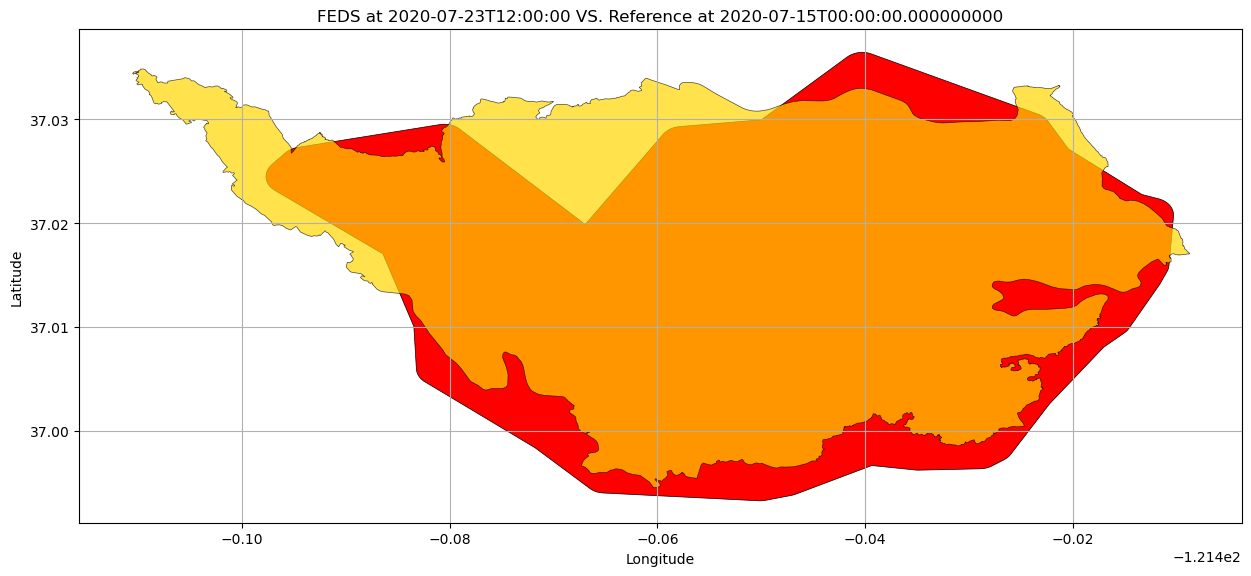

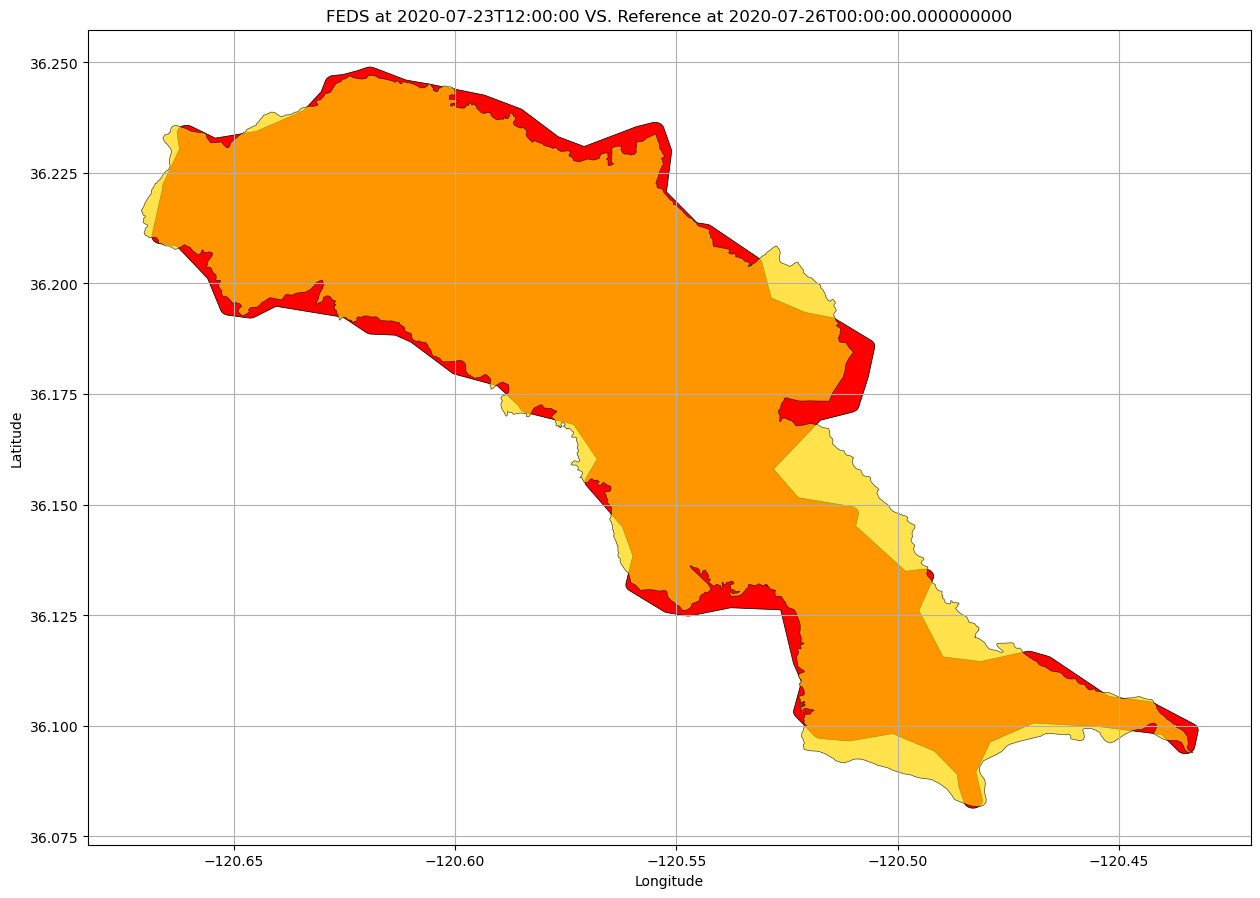

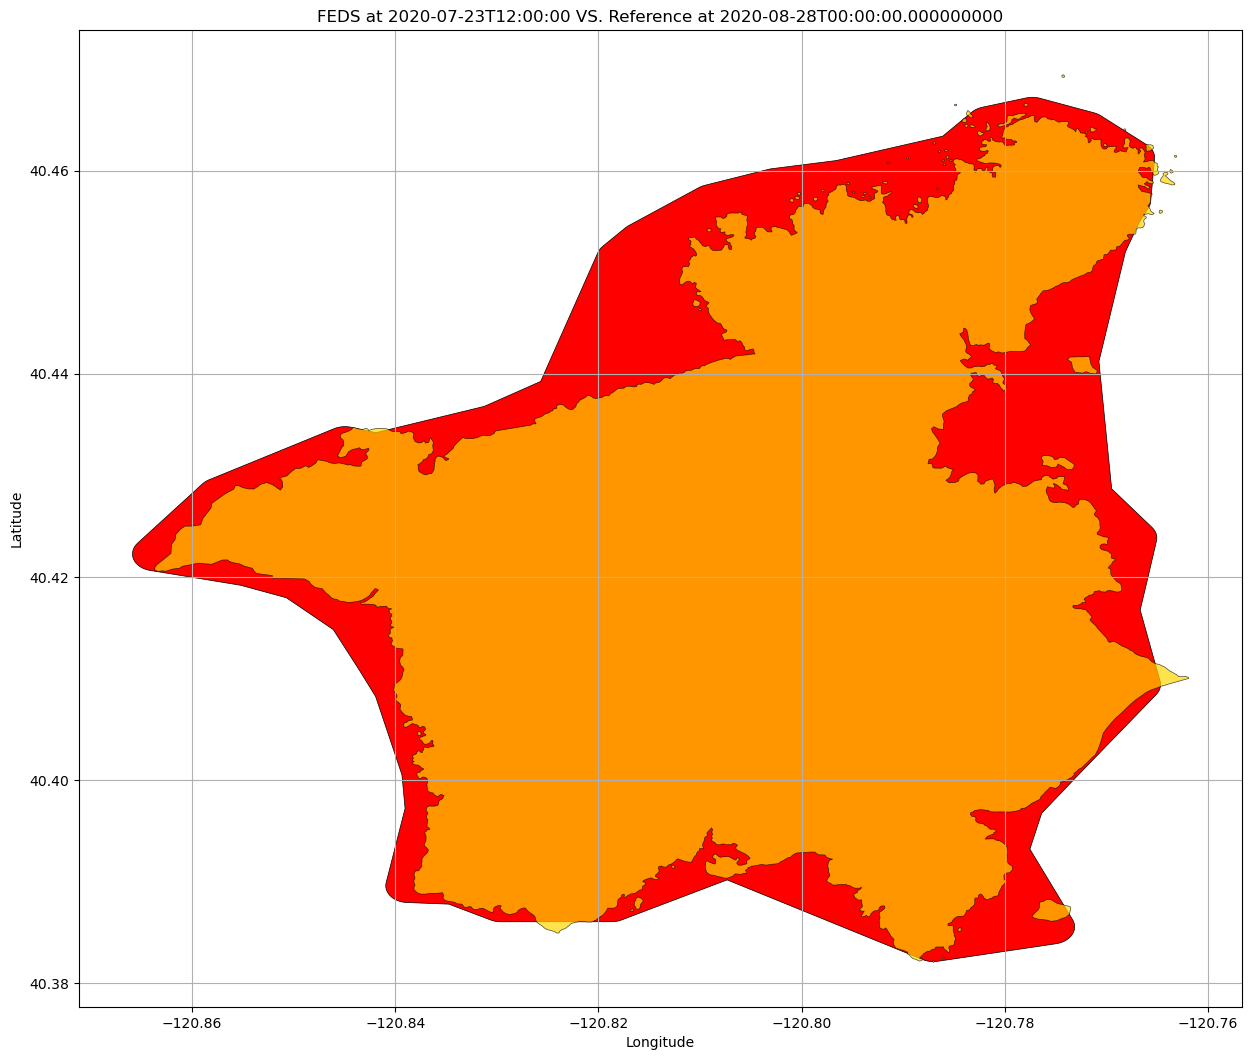

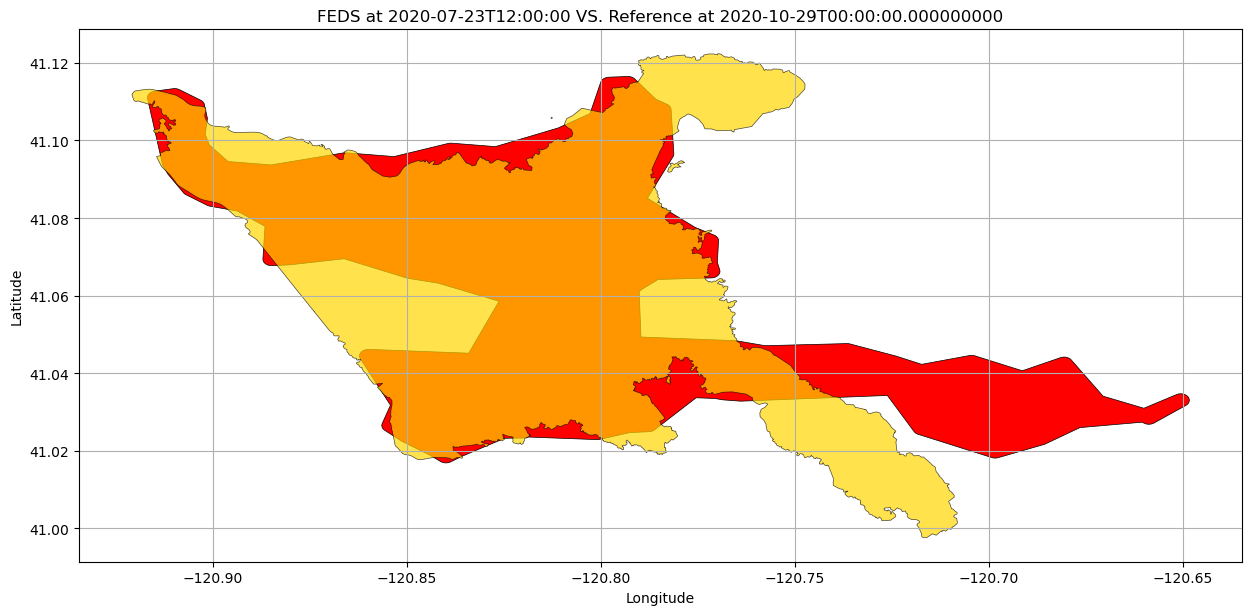

PLOTTING COMPLETE


CSV output complete! Check file /projects/my-public-bucket/VEDA-PEC/test_output_csv.csv for results. NOTE: None result rows were excluded.


In [4]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')

feds_firenrt = InputFEDS(
                 feds_title, 
                 feds_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 feds_access_type,
                 feds_limit,
                 feds_filter,
                 feds_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                feds_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

### Visualize/Print Results Via direct indices - See log output above for indices

1465 AGAINST REFERENCE POLYGON AT INDEX 5039 - 6 to 15th
 INDEX 1341 AGAINST REFERENCE POLYGON AT INDEX 5081- 23 to august -> search only on feds applied

In [5]:
feds_kincade = feds_firenrt.polygons[feds_firenrt.polygons['index'] == 1341] # <-- thats the index in (41, 11287)! 
feds_kincade.head()

,geometry,duration,farea,fireid,flinelen,fperim,meanfrp,n_newpixels,n_pixels,ogc_fid,pixden,t,index


In [6]:
nifc_match = nifc_search.polygons[nifc_search.polygons['index'] == 5081] # <-- thats the index in (41, 11287)! 
nifc_match.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,UNIT_ID,POO_RESP_I,FEATURE_CA,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,geometry,DATE_NOT_NONE,DATE_LEN_VALID,DATE_CUR_STAMP,index
5081,5082,Mixed Collection Methods,20200828,795DCBB1-F228-4F7B-9C92-14999DC4B397,21745,None,2020-CALMU-00003874,2020,00003874,HOG,CALMU,None,Wildfire,9566.36,None,CalFire FRAP,CDF,2020.0,6.686694e+07,85678.347302,"MULTIPOLYGON (((-120.787 40.382, -120.787 40.3...",True,True,2020-08-28,5081


In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd

def __plot_output():
        """ generate plots for all successful (non-None) indices
            include metadata relevant to project
            
            each match pair == separate plot image
        """
        print("\n")
        print("PLOTTING ON: BEGIN PLOT OUTPUT")
        
        # fetch dict vals
        calculations = my_output._calculations
        
        # poly + time fetch
        feds_polygons = my_output._feds_input.polygons
        ref_polygons = my_output._ref_input.polygons
        
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        
        # TODO generate series of plots for all non-None results
        for pair in calculations['index_pairs']:
            # coresponding index
            i = calculations['index_pairs'].index(pair)
            # ignore none value results
            if all( value is None for value in 
                    [
                        calculations['ratio'][i],
                        calculations['accuracy'][i],
                        calculations['precision'][i],
                        calculations['recall'][i],
                        calculations['iou'][i],
                        calculations['f1'][i],
                        calculations['symm_ratio'][i]
                    ]
                ):
                    continue
            
            # poly extraction
            feds_poly = feds_polygons[feds_polygons['index'] == calculations['index_pairs'][i][0]]
            ref_poly = ref_polygons[ref_polygons['index'] == calculations['index_pairs'][i][1]]
            feds_time = feds_poly.t.values[0]
            ref_time = ref_poly['DATE_CUR_STAMP'].values[0]
            
            # apply indices
            index1, index2 = pair
            feds_poly = feds_polygons[feds_polygons['index'] == index1]
            ref_poly = ref_polygons[ref_polygons['index'] == index2]

            # new fig per pair
            fig, ax = plt.subplots(figsize=(15, 15))
            
            world.plot(ax=ax, color='lightgrey', edgecolor='black')
            feds_poly.plot(ax=ax, legend=True, label="FEDS Fire Estimate", color="red",edgecolor="black", linewidth=0.5 )
            ref_poly.plot(ax=ax, legend=True, label="NIFC Nearest Date + Intersection", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
            
            # show plot
            ax.set_title(f"FEDS at {feds_time} VS. Reference at {ref_time}")
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            plt.grid(True)
            plt.show()

        
        print("PLOTTING COMPLETE")



PLOTTING ON: BEGIN PLOT OUTPUT


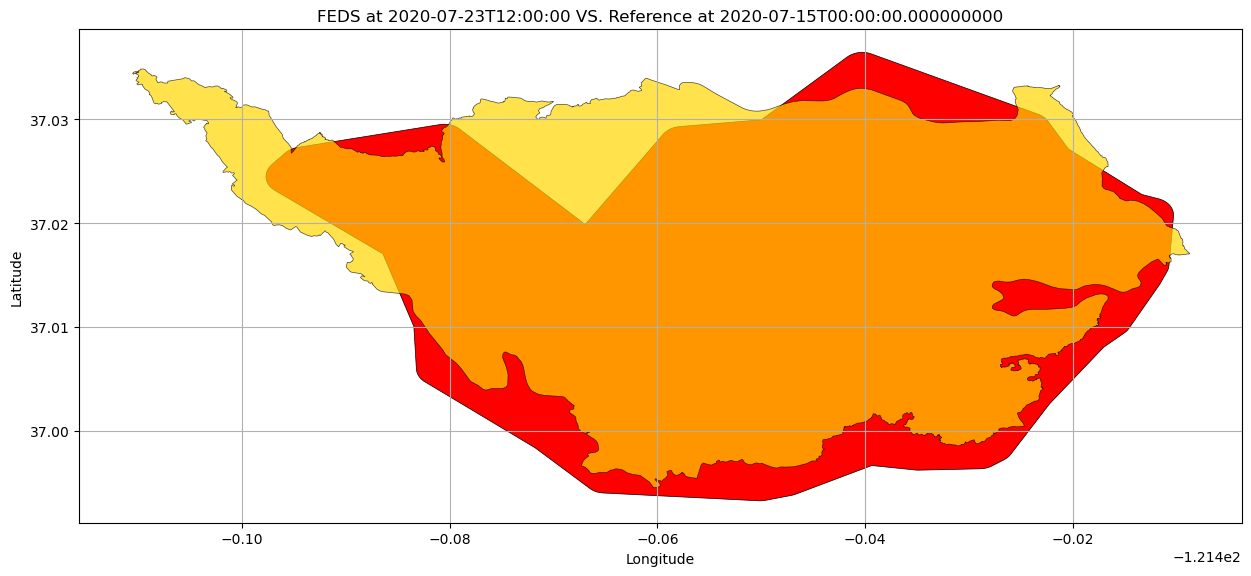

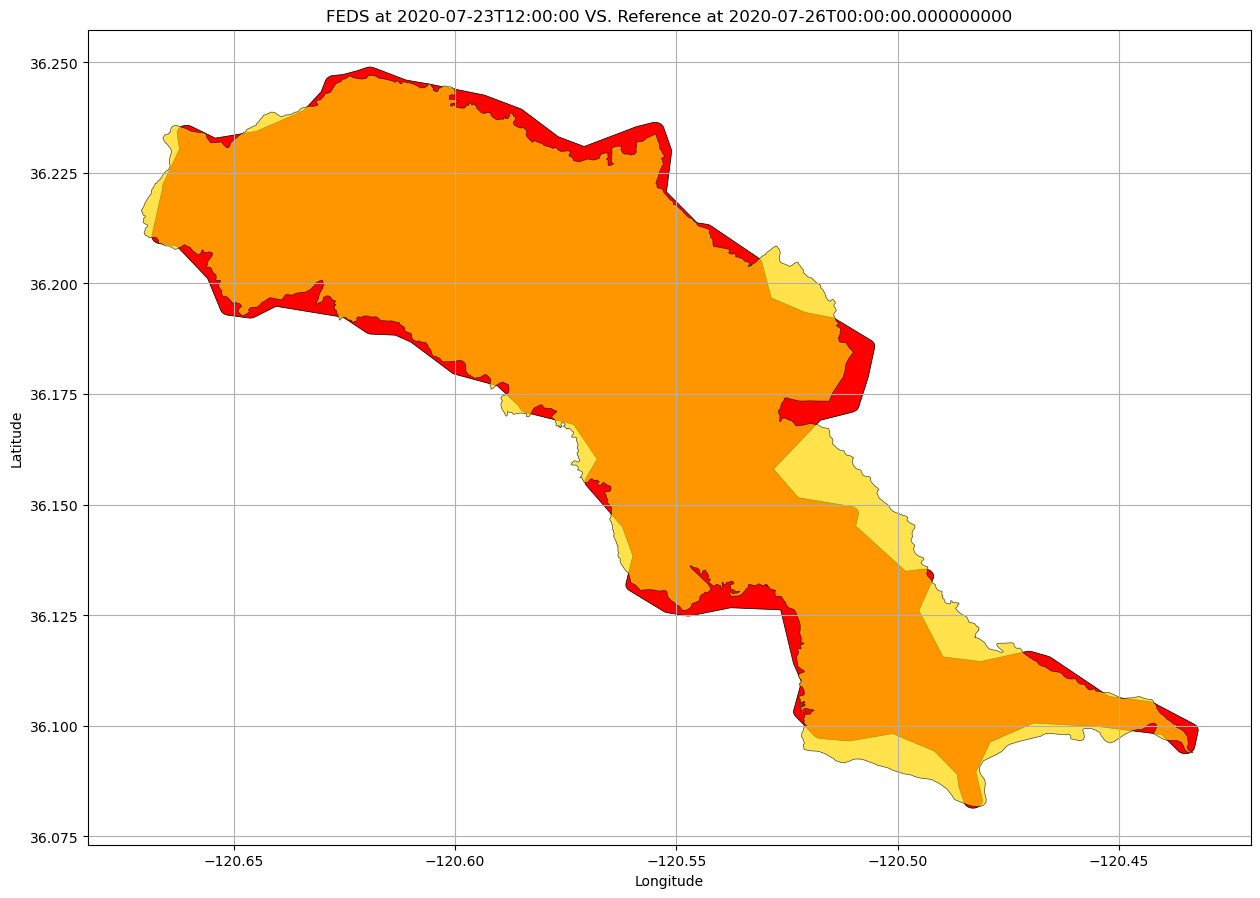

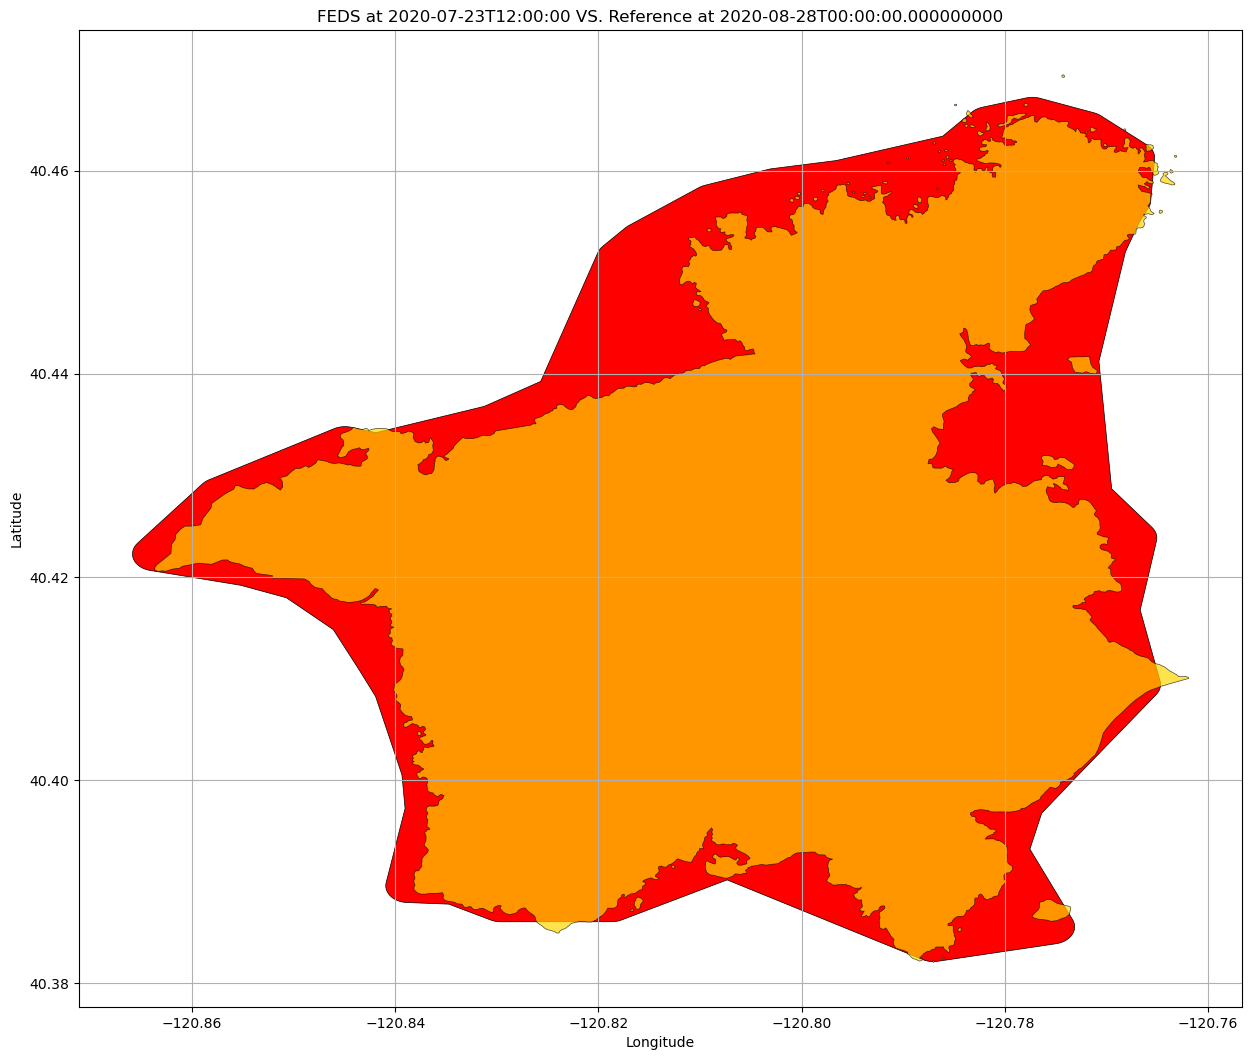

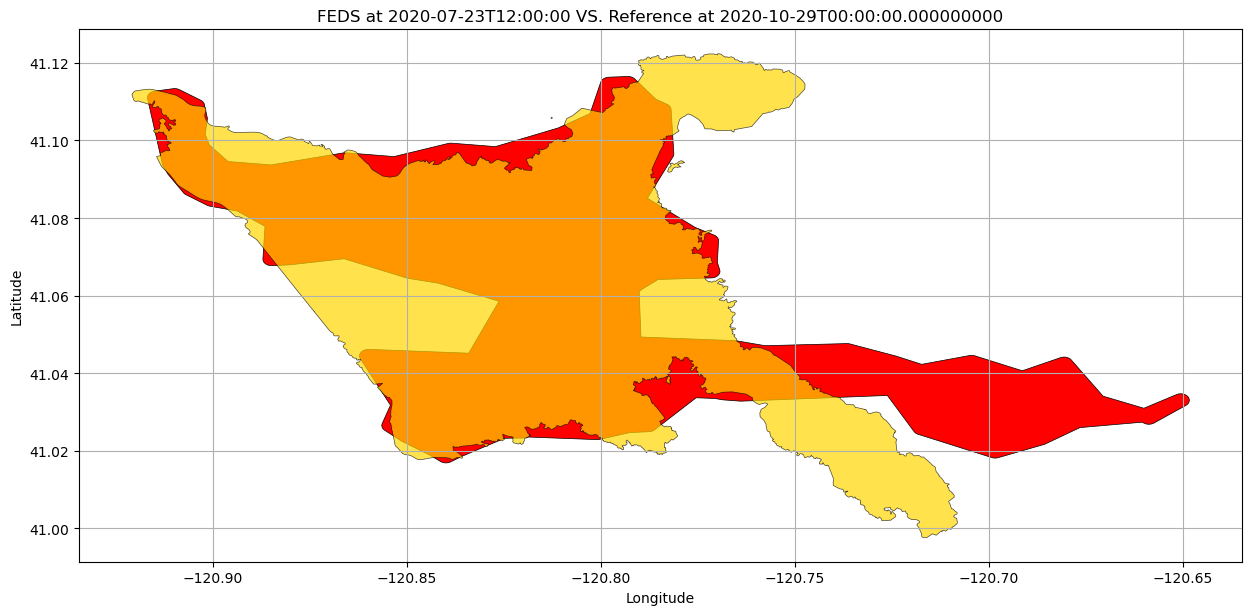

PLOTTING COMPLETE


In [9]:
__plot_output()

SAMPLE PLOTTING FEDS V. REFERENCE


BLUE: FEDS. Kincade Fire Estimate
GOLD: NIFC Reference Match


FEDS date: 2020-07-23T12:00:00
NIFC Reference date: 2020-08-28T00:00:00.000000000




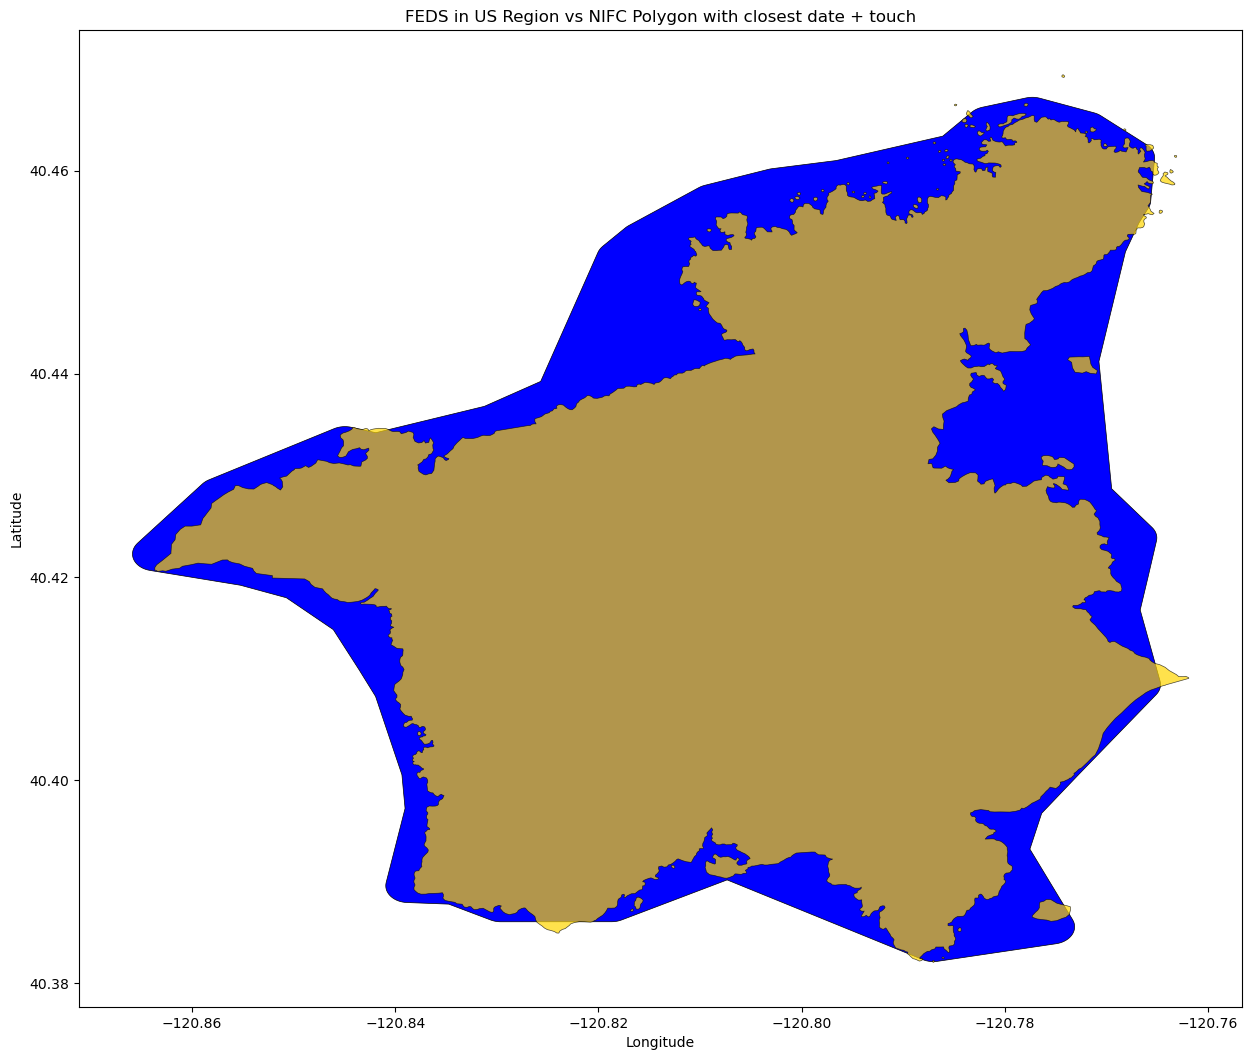

In [10]:
# for debugging purposes this is here

import matplotlib.pyplot as plt

print('SAMPLE PLOTTING FEDS V. REFERENCE')
print('\n')
print('BLUE: FEDS. Kincade Fire Estimate')
print('GOLD: NIFC Reference Match')
print('\n')
print(f"FEDS date: {feds_kincade.t.values[0]}")
print(f"NIFC Reference date: {nifc_match['DATE_CUR_STAMP'].values[0]}")
print('\n')

fig, ax = plt.subplots(figsize=(15, 15))

# feds_kincade.t.values[0]

# plot search results/what calculation is pulling from
v = feds_kincade.plot(ax=ax, legend=True, label="FEDS Fire Estimate", color="blue",edgecolor="black", linewidth=0.5 )
n = nifc_match.plot(ax=ax, legend=True, label="NIFC Nearest Date + Intersection", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("FEDS in US Region vs NIFC Polygon with closest date + touch")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()
